In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
%matplotlib inline

In [4]:
from matplotlib import rcParams 
rcParams.update({'font.size': 18})
from matplotlib.ticker import PercentFormatter

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [2]:
tf.__version__

'2.2.0'

In [72]:
# tf.enable_eager_execution()

In [6]:
tf.executing_eagerly()

True

In [142]:
pickle_in = open("../data/nitrate.pickle", "rb")
nitrate = pickle.load(pickle_in)
nitrate.describe()

,Year,Yday,Hour,PRESSURE,TEMPERATURE_VALUE,SALINITY_VALUE,NITRATE_VALUE
count,1.260600e+04,1.260600e+04,12606.000000,1.260600e+04,1.260600e+04,1.260600e+04,12606.00000
mean,-8.585584e-15,5.862006e-17,0.000000,-4.960159e-17,7.214776e-16,-3.158268e-14,3.82849
std,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,3.65113
min,-1.864557e+00,-1.803079e+00,-0.284946,-1.472396e+00,-2.506836e+00,-3.807207e+00,0.02000
25%,-6.864360e-01,-8.515868e-01,-0.284946,-8.213073e-01,-7.324980e-01,-6.677203e-01,0.70000
50%,-5.206285e-02,5.135982e-02,-0.284946,-1.702187e-01,-1.401559e-01,6.618571e-02,2.40000
75%,4.916855e-01,8.377972e-01,-0.284946,8.064143e-01,6.153939e-01,6.940831e-01,6.60000
max,3.301052e+00,1.731035e+00,3.732979,2.336473e+00,3.537563e+00,2.602239e+00,20.00000


In [143]:
len(nitrate.index)

12606

In [9]:
nitrate.mean(), np.max(nitrate), np.min(nitrate)

(Year                 1.059637e-13
 Yday                 2.489943e-16
 Hour                 3.907400e-14
 PRESSURE            -5.485062e-16
 TEMPERATURE_VALUE    6.659577e-16
 SALINITY_VALUE      -3.076302e-14
 NITRATE_VALUE        3.828490e+00
 dtype: float64, Year                  3.301052
 Yday                  1.731035
 Hour                  3.732979
 PRESSURE              2.336473
 TEMPERATURE_VALUE     3.537563
 SALINITY_VALUE        2.602239
 NITRATE_VALUE        20.000000
 dtype: float64, Year                -1.864557
 Yday                -1.803079
 Hour                -0.284946
 PRESSURE            -1.472396
 TEMPERATURE_VALUE   -2.506836
 SALINITY_VALUE      -3.807207
 NITRATE_VALUE        0.020000
 dtype: float64)

(array([5.739e+03, 2.126e+03, 1.245e+03, 1.322e+03, 1.207e+03, 6.700e+02,
        2.420e+02, 4.100e+01, 1.000e+01, 4.000e+00]),
 array([ 0.02 ,  2.018,  4.016,  6.014,  8.012, 10.01 , 12.008, 14.006,
        16.004, 18.002, 20.   ]),
 <a list of 10 Patch objects>)

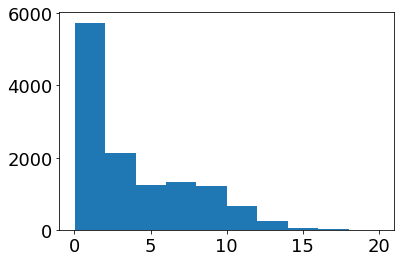

In [10]:
plt.hist(nitrate.NITRATE_VALUE)

(array([   5.,   15.,  597.,  687., 1385., 1289., 1765., 2054., 2378.,
        2403.]),
 array([ 6.08797699,  6.74931542,  7.41065384,  8.07199226,  8.73333068,
         9.3946691 , 10.05600753, 10.71734595, 11.37868437, 12.04002279,
        12.70136121]),
 <a list of 10 Patch objects>)

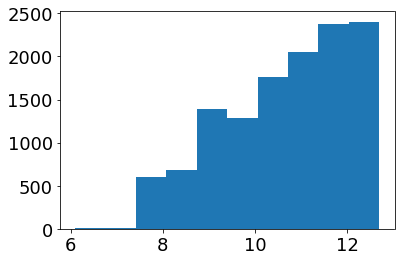

In [77]:
nitrate_logTrans = nitrate.copy()
nitrate_logTrans.NITRATE_VALUE = np.log(nitrate_logTrans.NITRATE_VALUE) + 10
plt.hist(nitrate_logTrans.NITRATE_VALUE)

(array([  20., 1262., 1101., 1389., 1467., 1726., 1306., 1598., 1939.,
         770.]),
 array([ 7.42275077,  8.05530525,  8.68785973,  9.32041422,  9.9529687 ,
        10.58552318, 11.21807766, 11.85063214, 12.48318663, 13.11574111,
        13.74829559]),
 <a list of 10 Patch objects>)

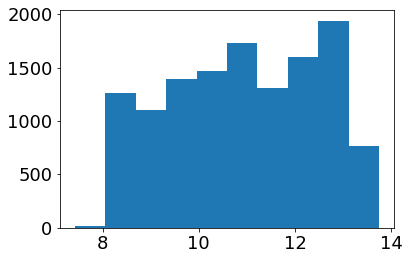

In [8]:
from scipy.stats import boxcox
nitrate_boxcoxTrans = nitrate.copy()
nitrate_boxcoxTrans.NITRATE_VALUE, lambda_ = boxcox(nitrate_boxcoxTrans.NITRATE_VALUE)
nitrate_boxcoxTrans.NITRATE_VALUE = nitrate_boxcoxTrans.NITRATE_VALUE + 10
plt.hist(nitrate_boxcoxTrans.NITRATE_VALUE)

In [30]:
lambda_.astype("float32")

0.23057438

In [31]:
def invboxcox(y,ld):
   if ld == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(ld*y+1)/ld))

def invboxcox_tensor(y,ld):
   ld = ld.astype("float32")
   if ld == 0:
      return(tf.math.exp(y))
   else:
      return(tf.math.exp(tf.math.log(tf.math.divide(tf.math.add(tf.math.multiply(ld,y),1),ld))))

In [92]:
nitrateval = invboxcox(nitrate_boxcoxTrans.NITRATE_VALUE - 10, lambda_)
nitrateval.tail(), nitrate.NITRATE_VALUE.tail()

(15535     0.12
 15537     0.21
 15540     8.69
 15542    10.48
 15543    10.91
 Name: NITRATE_VALUE, dtype: float64, 15535     0.12
 15537     0.21
 15540     8.69
 15542    10.48
 15543    10.91
 Name: NITRATE_VALUE, dtype: float64)

In [93]:
nitrate = nitrate_boxcoxTrans

In [52]:
# drop Hour
nitrate.drop(columns=['Hour'], inplace=True)
nitrate.describe()

,Year,Yday,PRESSURE,TEMPERATURE_VALUE,SALINITY_VALUE,NITRATE_VALUE
count,1.319300e+04,1.319300e+04,1.319300e+04,1.319300e+04,1.319300e+04,13193.000000
mean,-1.516629e-15,-6.032046e-17,3.231453e-17,-1.271038e-15,7.471120e-15,3.982172
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.744430
min,-1.890652e+00,-1.788631e+00,-1.220091e+00,-3.093349e+00,-2.213066e+01,0.020000
25%,-6.959712e-01,-8.599608e-01,-7.283696e-01,-7.209295e-01,-4.641692e-01,0.700000
50%,-5.268161e-02,4.936176e-02,9.212555e-03,-1.211264e-01,8.688615e-02,2.600000
75%,4.987095e-01,8.426006e-01,6.238643e-01,6.143669e-01,5.878456e-01,6.900000
max,3.347563e+00,1.732576e+00,6.155730e+00,3.440528e+00,3.186572e+00,25.800000


In [132]:
## Train test split
train_dataset = nitrate.sample(frac=0.80, random_state=0)
test_dataset  = nitrate.drop(train_dataset.index)

In [133]:
train_labels = train_dataset.pop('NITRATE_VALUE')
test_labels = test_dataset.pop('NITRATE_VALUE')

In [250]:
# save train and test datasets based on nitrate.pickle
# nitrate between 0 and 24
# train fraction = 0.8
# No data transformations
pickle_out = open("../data/nitrate_train-test_data-labels.pickle", "wb")
pickle.dump([train_dataset, test_dataset, train_labels, test_labels], pickle_out)
pickle_out.close()

In [10]:
with open("../data/nitrate_train-test_data-labels.pickle", "rb") as pickle_in:
    data = pickle.load(pickle_in)
    train_dataset = data[0]
    test_dataset = data[1]
    train_labels = data[2]
    test_labels = data[3]

In [13]:
2.6/test_labels.mean()*100

68.50521998781359

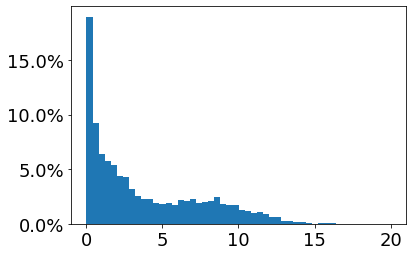

In [21]:
plt.hist(train_labels, bins = 50, weights=np.ones(len(train_labels))/len(train_labels))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

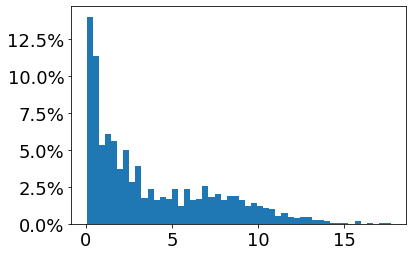

In [23]:
plt.hist(test_labels, bins = 50, weights=np.ones(len(test_labels))/len(test_labels))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

In [33]:
list((train_labels < 0.5).index)

[13264,
 286,
 10142,
 3393,
 12906,
 14313,
 5558,
 9762,
 6060,
 7730,
 1119,
 14236,
 4409,
 9054,
 14855,
 3863,
 406,
 14764,
 8486,
 8186,
 12572,
 12104,
 1433,
 10590,
 12133,
 2107,
 1872,
 8798,
 10571,
 1618,
 11358,
 9118,
 10883,
 1943,
 7105,
 13044,
 14770,
 6771,
 4588,
 1439,
 3667,
 5362,
 5812,
 11888,
 5900,
 15073,
 1480,
 12023,
 9493,
 11834,
 11021,
 6625,
 7795,
 6257,
 9910,
 7344,
 4150,
 11481,
 6647,
 1690,
 3122,
 10680,
 10368,
 3110,
 6787,
 15443,
 6304,
 11916,
 11880,
 12896,
 2244,
 4696,
 4396,
 12021,
 9308,
 10924,
 14168,
 10010,
 3367,
 11758,
 12176,
 8839,
 4850,
 13521,
 15109,
 6565,
 2947,
 5464,
 12473,
 5902,
 11452,
 11570,
 6716,
 7161,
 11109,
 14292,
 3308,
 6463,
 6573,
 13977,
 9304,
 4591,
 6214,
 14470,
 15068,
 8386,
 14726,
 11558,
 11680,
 2494,
 1619,
 13744,
 12312,
 6458,
 6635,
 7562,
 5324,
 7583,
 13975,
 4623,
 7891,
 1867,
 3686,
 2542,
 15463,
 12890,
 2847,
 14924,
 3397,
 5942,
 11038,
 1831,
 9527,
 14534,
 12123,
 

In [40]:
train_dataset.loc[random.sample(list((train_labels < 0.5).index), int(len(train_labels < 0.5)/2))]

,Year,Yday,Hour,PRESSURE,TEMPERATURE_VALUE,SALINITY_VALUE
2557,-1.139560,0.925179,-0.284946,-1.472396,0.701310,1.827560
6918,-0.233312,1.439762,-0.284946,1.131959,-1.359789,-0.496476
10851,0.310436,1.614526,-0.284946,0.806414,-0.862437,-0.635102
12164,0.582310,1.109652,-0.284946,-1.146852,-0.320278,-0.512785
9363,0.129187,1.575689,-0.284946,0.155326,0.947746,1.379062
...,...,...,...,...,...,...
9064,0.129187,0.206705,-0.284946,0.155326,-0.333720,0.098804
9387,0.219811,-1.744824,-0.284946,1.131959,-1.081989,-0.969437
13219,0.854184,-0.570023,-0.284946,-0.170219,1.279314,1.582925
7482,-0.142688,0.556233,-0.284946,-0.170219,-0.418852,0.115113


In [135]:
# train_labels = (train_labels - train_mean)/train_std
# test_labels = (test_labels - train_mean)/train_std

In [6]:
train_dataset.head()

,Year,Yday,Hour,PRESSURE,TEMPERATURE_VALUE,SALINITY_VALUE
13264,0.854184,-0.094277,-0.284946,-0.821307,-0.387488,1.109963
286,-1.683308,-0.618568,-0.284946,0.969186,-0.418852,-0.529094
10142,0.310436,-0.977805,-0.284946,1.131959,-0.508465,-0.553557
3393,-0.867685,-0.453514,-0.284946,0.155326,0.508642,-0.227377
12906,0.763560,0.730997,-0.284946,-0.495763,0.177074,1.615543


In [8]:
len(train_dataset), len(test_dataset)

(10085, 2521)

### The Model

In [38]:
class invboxcox_mape(keras.losses.Loss):
    """
    A loss/metric that (de)scales true and predicted values into absolute units before calculating mean absolute percentage error (mape).
    Args:
        mu: mean (usually training data mean)
        sd: standard dev (usually based on training data)
        reduction: Type of tf.keras.losses.Reduction to apply to loss.
        name: name of loss function
    """
    def __init__(self, lambda_, reduction=keras.losses.Reduction.AUTO, name='invboxcox_mape'):
        super().__init__(reduction=reduction, name=name)
        self.lambda_= lambda_
    
    def call(self, y_true, y_pred):
        y_true = invboxcox_tensor(tf.math.subtract(y_true, 10), lambda_)
        y_pred = invboxcox_tensor(tf.math.subtract(y_pred, 10), lambda_)
        return tf.math.reduce_mean(tf.abs((y_true - y_pred)/y_true))

In [227]:
class invlog_mape(keras.losses.Loss):
    """
    A loss/metric that (de)scales true and predicted values into absolute units before calculating mean absolute percentage error (mape).
    Args:
        mu: mean (usually training data mean)
        sd: standard dev (usually based on training data)
        reduction: Type of tf.keras.losses.Reduction to apply to loss.
        name: name of loss function
    """
#     def __init__(self, lambda_, reduction=keras.losses.Reduction.AUTO, name='invlog_mape'):
#         super().__init__(reduction=reduction, name=name)
#         self.lambda_= lambda_
    
    def call(self, y_true, y_pred):
        y_true = tf.math.exp(tf.math.subtract(y_true, 10))
        y_pred = tf.math.exp(tf.math.subtract(y_pred, 10))
        return tf.math.reduce_mean(tf.abs((y_true - y_pred)/y_true))

In [41]:
def build_model():
    model = keras.Sequential([
      layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
#       layers.Dense(64, activation='relu'),
#       layers.Dense(128, activation='tanh'),
#       layers.Dense(8, activation='relu'),
      layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.Adam(lr=0.0001)
    
    model.compile(loss= tf.keras.losses.mean_absolute_percentage_error,#invlog_mape(), #'mse',#descaled_mape(mu = train_mean, sd = train_std),
                 optimizer=optimizer,
                 metrics=[#descaled_mape(mu = train_mean, sd = train_std), 
                     'mae', 'mse', tf.keras.metrics.MeanAbsolutePercentageError()])
    
    return model

In [111]:
from tensorflow.keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [14]:
def build_model():
    model = keras.Sequential([
      layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())], kernel_regularizer=regularizers.l2(0.4)),
      layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.4)),
#       layers.Dense(16, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
      layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.4)),
      layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.Adam(lr=0.0001)
    
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae', 'mse', tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanSquaredLogarithmicError()])
    
    return model

In [15]:
model = build_model()

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                112       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Try out model with example batch
example_batch = train_dataset[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.07652263],
       [-0.20501605],
       [-0.00732486],
       [-0.105623  ],
       [-0.07041334],
       [-0.03824678],
       [-0.39343506],
       [-0.02422118],
       [-0.09318259],
       [-0.14407124]], dtype=float32)

In [16]:
model = build_model()
minx = model.evaluate(train_dataset, train_labels)[0]
numtries = 0
while (numtries < 25):
    tmpmodel = build_model()
    x = tmpmodel.evaluate(train_dataset, train_labels)[0]
    if x < minx:
        model = tmpmodel
        minx = x
    numtries += 1
minx        

316/316 [==============================] - 0s 826us/step - loss: 63.2874 - mae: 3.7614 - mse: 27.2486 - mean_absolute_percentage_error: 98.7810 - root_mean_squared_error: 5.2200 - mean_squared_logarithmic_error: 2.0065


61.04639434814453

In [18]:
model = build_model()

In [92]:
# Test with transforming Yday into a periodic variable but little improvement in accuracy


## Train the model
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 10 == 0: print('loss: {:7.4f}, val_loss: {:7.4f}' .format(logs['loss'], logs['val_loss']))
    print('.', end='')

# early stopping callback
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

EPOCHS = 1000

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot(), es_callback])

loss: 52.9632, val_loss: 43.6384
..........loss:  7.9639, val_loss:  7.4649
..........loss:  5.9365, val_loss:  5.6491
.....

KeyboardInterrupt: 

In [17]:
## Train the model
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 10 == 0: print('loss: {:7.4f}, val_loss: {:7.4f}' .format(logs['loss'], logs['val_loss']))
    print('.', end='')

# early stopping callback
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

EPOCHS = 10000

history = model.fit(
  train_dataset, train_labels, batch_size=1024,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot(), es_callback])

loss: 60.8144, val_loss: 60.6198
..........loss: 55.6129, val_loss: 55.3801
..........loss: 49.7209, val_loss: 49.4616
..........loss: 43.5012, val_loss: 43.2133
..........loss: 37.4604, val_loss: 37.1788
..........loss: 32.4253, val_loss: 32.1633
..........loss: 28.7904, val_loss: 28.5385
..........loss: 26.1732, val_loss: 25.9057
..........loss: 24.0771, val_loss: 23.7949
..........loss: 22.2704, val_loss: 21.9800
..........loss: 20.6658, val_loss: 20.3723
..........loss: 19.2234, val_loss: 18.9296
..........loss: 17.9183, val_loss: 17.6261
..........loss: 16.7341, val_loss: 16.4450
..........loss: 15.6586, val_loss: 15.3718
..........loss: 14.6812, val_loss: 14.3975
..........loss: 13.7930, val_loss: 13.5130
..........loss: 12.9864, val_loss: 12.7091
..........loss: 12.2543, val_loss: 11.9803
..........loss: 11.5899, val_loss: 11.3179
..........loss: 10.9873, val_loss: 10.7181
..........loss: 10.4408, val_loss: 10.1739
..........loss:  9.9451, val_loss:  9.6803
..........loss:  9.49

In [18]:
## Save model
model.save('../data/saved_models/nitrate_model_mseloss_l2regularization.h5')

In [19]:
# save history
pickle_out = open("../data/nitrate_model_mseloss_l2regularization_history.pickle", "wb")
pickle.dump(pd.DataFrame(history.history), pickle_out)
pickle_out.close()

In [120]:
# with O2 as predictor
## Train the model
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 10 == 0: print('loss: {:7.4f}, val_loss: {:7.4f}' .format(logs['loss'], logs['val_loss']))
    print('.', end='')

# early stopping callback
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

EPOCHS = 10000

history = model.fit(
  train_dataset, train_labels, batch_size=1024,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot(), es_callback])

loss: 60.8228, val_loss: 60.5866
..........loss: 55.2806, val_loss: 54.9785
..........loss: 48.7662, val_loss: 48.3995
..........loss: 42.2755, val_loss: 41.9037
..........loss: 36.5896, val_loss: 36.2461
..........loss: 32.2745, val_loss: 31.9518
..........loss: 29.1276, val_loss: 28.8058
..........loss: 26.6747, val_loss: 26.3434
..........loss: 24.6124, val_loss: 24.2749
..........loss: 22.8049, val_loss: 22.4667
..........loss: 21.1865, val_loss: 20.8519
..........loss: 19.7233, val_loss: 19.3935
..........loss: 18.3936, val_loss: 18.0700
..........loss: 17.1823, val_loss: 16.8654
..........loss: 16.0777, val_loss: 15.7675
..........loss: 15.0695, val_loss: 14.7665
..........loss: 14.1507, val_loss: 13.8526
..........loss: 13.3143, val_loss: 13.0217
..........loss: 12.5547, val_loss: 12.2664
..........loss: 11.8638, val_loss: 11.5807
..........loss: 11.2357, val_loss: 10.9566
..........loss: 10.6650, val_loss: 10.3895
..........loss: 10.1467, val_loss:  9.8752
..........loss:  9.67

In [140]:
## Save model
model.save('../data/saved_models/nitrate_model_mseloss_l2regularization_O2.h5')

In [141]:
# save history
pickle_out = open("../data/nitrate_model_mseloss_l2regularization_O2_history.pickle", "wb")
pickle.dump(pd.DataFrame(history.history), pickle_out)
pickle_out.close()

In [157]:
# load model
model = keras.models.load_model('../data/saved_models/nitrate_model.h5')

In [8]:
# load history
pickle_in = open("../data/nitrate_model_mseloss_l2regularization_O2_history.pickle", "rb")
history2 = pickle.load(pickle_in)
pickle_in.close()

In [9]:
history2

,loss,mae,mse,mean_absolute_percentage_error,root_mean_squared_error,mean_squared_logarithmic_error,val_loss,val_mae,val_mse,val_mean_absolute_percentage_error,val_root_mean_squared_error,val_mean_squared_logarithmic_error
0,60.535431,3.457066,24.022173,92.669449,4.901242,1.393907,60.669739,3.466914,24.295570,91.924660,4.929054,1.368216
1,59.963833,3.429759,23.684582,93.927963,4.866681,1.341302,60.090946,3.438689,23.948540,93.096344,4.893724,1.316604
2,59.389503,3.402247,23.340595,95.330734,4.831211,1.290305,59.504562,3.410098,23.590752,94.395752,4.857031,1.266056
3,58.805729,3.374216,22.984596,96.759880,4.794225,1.240620,58.911427,3.380932,23.223911,95.669411,4.819119,1.216910
4,58.216324,3.345852,22.619947,98.360710,4.756043,1.191957,58.308693,3.350932,22.843893,97.055397,4.779529,1.168429
...,...,...,...,...,...,...,...,...,...,...,...,...
8171,2.234245,0.815163,1.628738,70.924950,1.276220,0.085923,2.435157,0.839318,1.829166,67.687035,1.352466,0.090564
8172,2.234960,0.815855,1.629189,71.732155,1.276397,0.086281,2.435746,0.838872,1.829979,66.800087,1.352767,0.090220
8173,2.234093,0.815602,1.628100,71.728088,1.275970,0.086258,2.435162,0.839181,1.828688,68.022751,1.352290,0.090720
8174,2.234541,0.815585,1.628208,71.755783,1.276013,0.086307,2.435385,0.838035,1.829029,66.423782,1.352416,0.090138


In [139]:
pd.DataFrame(history.history)

,loss,mae,mse,mean_absolute_percentage_error,root_mean_squared_error,mean_squared_logarithmic_error,val_loss,val_mae,val_mse,val_mean_absolute_percentage_error,val_root_mean_squared_error,val_mean_squared_logarithmic_error
0,60.535431,3.457066,24.022173,92.669449,4.901242,1.393907,60.669739,3.466914,24.295570,91.924660,4.929054,1.368216
1,59.963833,3.429759,23.684582,93.927963,4.866681,1.341302,60.090946,3.438689,23.948540,93.096344,4.893724,1.316604
2,59.389503,3.402247,23.340595,95.330734,4.831211,1.290305,59.504562,3.410098,23.590752,94.395752,4.857031,1.266056
3,58.805729,3.374216,22.984596,96.759880,4.794225,1.240620,58.911427,3.380932,23.223911,95.669411,4.819119,1.216910
4,58.216324,3.345852,22.619947,98.360710,4.756043,1.191957,58.308693,3.350932,22.843893,97.055397,4.779529,1.168429
...,...,...,...,...,...,...,...,...,...,...,...,...
8171,2.234245,0.815163,1.628738,70.924950,1.276220,0.085923,2.435157,0.839318,1.829166,67.687035,1.352466,0.090564
8172,2.234960,0.815855,1.629189,71.732155,1.276397,0.086281,2.435746,0.838872,1.829979,66.800087,1.352767,0.090220
8173,2.234093,0.815602,1.628100,71.728088,1.275970,0.086258,2.435162,0.839181,1.828688,68.022751,1.352290,0.090720
8174,2.234541,0.815585,1.628208,71.755783,1.276013,0.086307,2.435385,0.838035,1.829029,66.423782,1.352416,0.090138


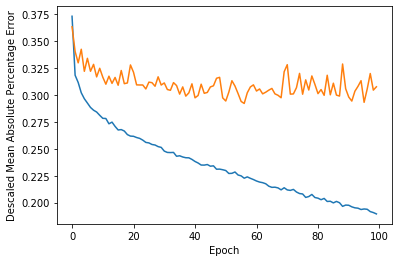

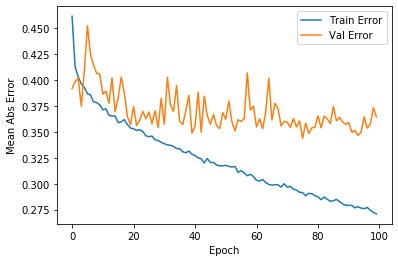

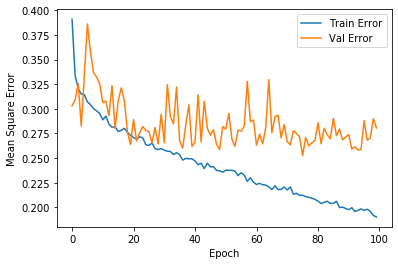

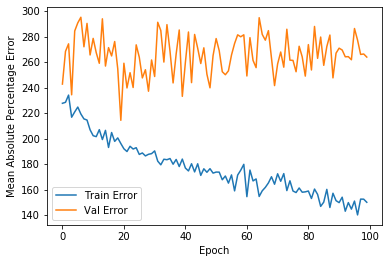

In [51]:
# def plot_history(history):
#   hist = pd.DataFrame(history.history)
#   hist['epoch'] = history.epoch

#   plt.figure()
#   plt.xlabel('Epoch')
#   plt.ylabel('Descaled Mean Absolute Percentage Error')
#   plt.plot(hist['epoch'], hist['descaled_mape'],
#            label='Train Error')
#   plt.plot(hist['epoch'], hist['val_descaled_mape'],
#            label = 'Val Error')
# #   plt.ylim([0.9,
    
#   plt.figure()
#   plt.xlabel('Epoch')
#   plt.ylabel('Mean Abs Error')
#   plt.plot(hist['epoch'], hist['mae'],
#            label='Train Error')
#   plt.plot(hist['epoch'], hist['val_mae'],
#            label = 'Val Error')
# #   plt.ylim([0.9,2])
#   plt.legend()

#   plt.figure()
#   plt.xlabel('Epoch')
#   plt.ylabel('Mean Square Error')
#   plt.plot(hist['epoch'], hist['mse'],
#            label='Train Error')
#   plt.plot(hist['epoch'], hist['val_mse'],
#            label = 'Val Error')
# #   plt.ylim([1.8,7])
#   plt.legend()

#   plt.figure()
#   plt.xlabel('Epoch')
#   plt.ylabel('Mean Absolute Percentage Error')
#   plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
#            label='Train Error')
#   plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
#            label = 'Val Error')
# #   plt.ylim([80,160])
#   plt.legend()
#   plt.show()


# plot_history(history)

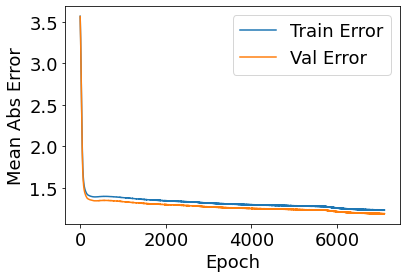

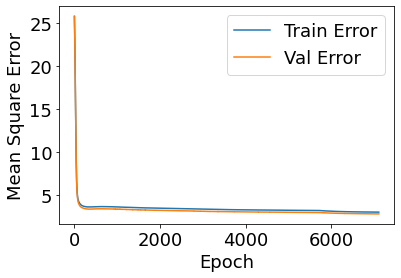

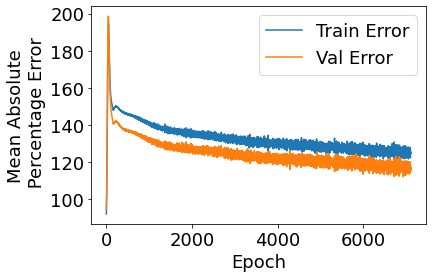

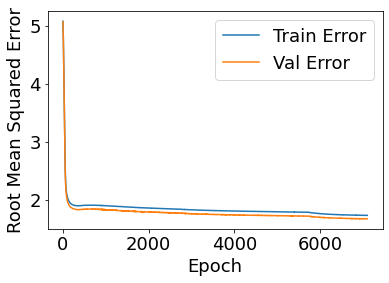

In [121]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
#   plt.ylim([0.9,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
#   plt.ylim([1.8,7])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute\n Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
#   plt.ylim([3,6])
  plt.legend()
    
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Root Mean Squared Error')
  plt.plot(hist['epoch'], hist['root_mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_root_mean_squared_error'],
           label = 'Val Error')
#   plt.ylim([3,6])
  plt.legend()
  plt.show()


plot_history(history)

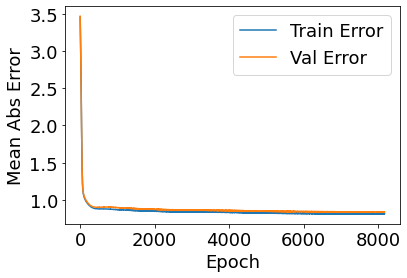

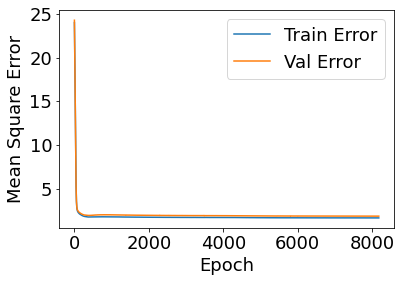

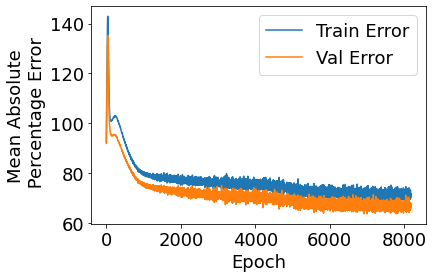

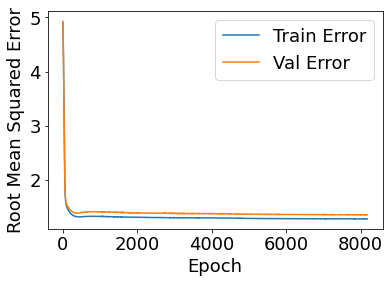

In [137]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
#   plt.ylim([0.9,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
#   plt.ylim([1.8,7])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute\n Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
#   plt.ylim([3,6])
  plt.legend()
    
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Root Mean Squared Error')
  plt.plot(hist['epoch'], hist['root_mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_root_mean_squared_error'],
           label = 'Val Error')
#   plt.ylim([3,6])
  plt.legend()
  plt.show()


plot_history(history)

In [5]:
with open("../data/nitrate_model_mseloss_l2regularization_history.pickle", "rb") as pickle_in:
    hist1 = pickle.load(pickle_in)
with open("../data/nitrate_model_mseloss_l2regularization_O2_history.pickle", "rb") as pickle_in:
    hist2 = pickle.load(pickle_in)

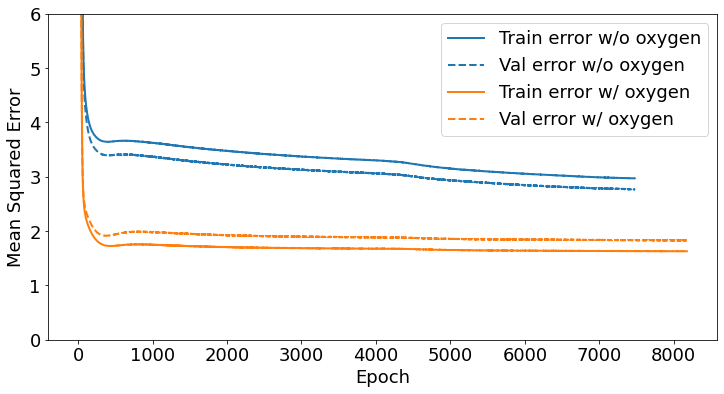

In [6]:
# hist = pd.DataFrame(history.history)
hist1['epoch'] = np.arange(1, len(hist1)+1, 1) #history.epoch
hist2['epoch'] = np.arange(1, len(hist2)+1, 1)
fig, ax = plt.subplots(figsize=(12,6))
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
line, = ax.plot(hist1['epoch'], hist1['mse'], linewidth=2,
         label='Train error w/o oxygen')
plt.plot(hist1['epoch'], hist1['val_mse'], color=line.get_color(), linestyle="--", linewidth=2,
         label = 'Val error w/o oxygen')
line, = ax.plot(hist2['epoch'], hist2['mse'], linewidth=2,
         label='Train error w/ oxygen')
plt.plot(hist2['epoch'], hist2['val_mse'], color=line.get_color(), linestyle="--", linewidth=2,
         label = 'Val error w/ oxygen')
# plt.title('Nitrate model without oxygen as a feature')
# plt.text(0.02, 0.9, "(a)", transform=ax.transAxes, fontsize=30)
plt.ylim([0,6])
plt.legend()

# hist = history2
# hist2['epoch'] = np.arange(1, len(hist2)+1, 1)
# fig, ax = plt.subplots(figsize=(10,5))
# plt.xlabel('Epoch')
# plt.ylabel('Mean Squared Error')
# plt.plot(hist2['epoch'], hist2['mse'],
#          label='Train Error')
# plt.plot(hist2['epoch'], hist2['val_mse'],
#          label = 'Val Error')
# plt.title('Nitrate model with oxygen as a feature')
# plt.text(0.02, 0.9, "(b)", transform=ax.transAxes, fontsize=30)
# plt.ylim([0,6])
# plt.legend()

# plt.show()

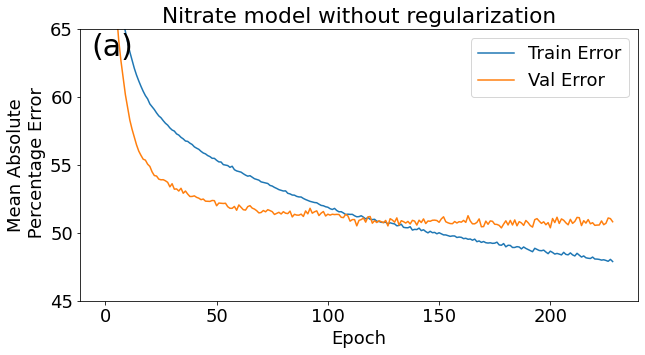

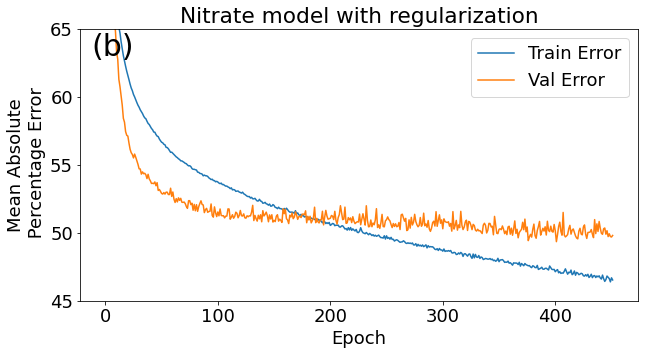

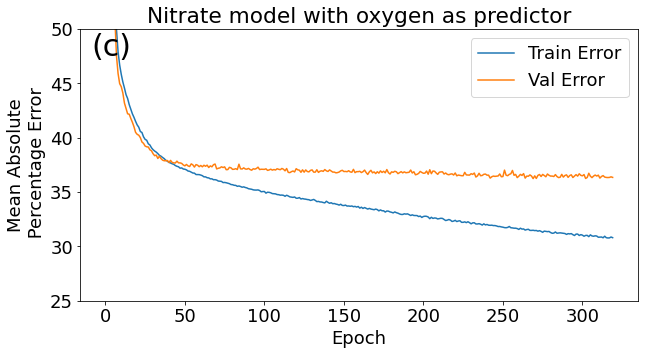

In [232]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
fig, ax = plt.subplots(figsize=(10,5))
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute\n Percentage Error')
plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
         label='Train Error')
plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
         label = 'Val Error')
plt.title('Nitrate model without regularization')
plt.text(0.02, 0.9, "(a)", transform=ax.transAxes, fontsize=30)
plt.ylim([45,65])
plt.legend()

hist = pd.DataFrame(history.history)
hist['epoch'] = history2.epoch
fig, ax = plt.subplots(figsize=(10,5))
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute\n Percentage Error')
plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
         label='Train Error')
plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
         label = 'Val Error')
plt.title('Nitrate model with regularization')
plt.text(0.02, 0.9, "(b)", transform=ax.transAxes, fontsize=30)
plt.ylim([45,65])
plt.legend()

# hist = pd.DataFrame(history3.history)
# hist['epoch'] = history3.epoch
# fig, ax = plt.subplots(figsize=(10,5))
# plt.xlabel('Epoch')
# plt.ylabel('Mean Absolute\n Percentage Error')
# plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
#          label='Train Error')
# plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
#          label = 'Val Error')
# plt.title('Nitrate model with oxygen as predictor')
# plt.text(0.02, 0.9, "(c)", transform=ax.transAxes, fontsize=30)
# plt.ylim([25,50])
# plt.legend()

plt.show()

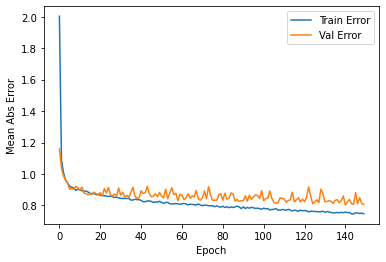

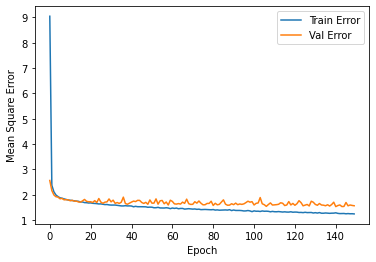

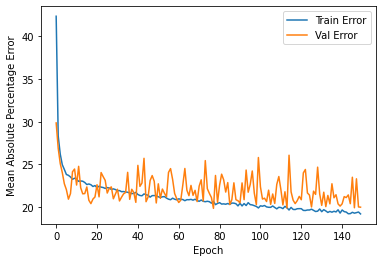

In [42]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
#   plt.ylim([0.9,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
#   plt.ylim([1.8,7])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
  #plt.ylim([80,160])
  plt.legend()
  plt.show()


plot_history(history)

In [162]:
# nitrate values between 0 (only <3% nitrate values are below 1) and 24 and pressure between 80 and 120 
loss, mae, mse, mape = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Percentage Error: {:5.2f}".format(mape))

9/9 - 0s - loss: 40.1256 - mae: 1.9316 - mse: 6.9815 - mean_absolute_percentage_error: 40.1256
Testing set Mean Abs Percentage Error: 40.13


In [233]:
# nitrate values between 0 and 24 
loss, mae, mse, mape = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Percentage Error: {:5.2f}".format(mape))

79/79 - 0s - loss: 53.3480 - mae: 1.3688 - mse: 4.0909 - mean_absolute_percentage_error: 53.3480
Testing set Mean Abs Percentage Error: 53.35


In [219]:
# nitrate values between 0 and 24 and model with regularization
loss, mae, mse, mape = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Percentage Error: {:5.2f}".format(mape))

79/79 - 0s - loss: 57.3333 - mae: 1.3449 - mse: 3.9513 - mean_absolute_percentage_error: 52.6206
Testing set Mean Abs Percentage Error: 52.62


In [182]:
# nitrate values between 0 and 24 with oxygen as a predictor
loss, mae, mse, mape = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Percentage Error: {:5.2f}".format(mape))

67/67 - 0s - loss: 40.9788 - mae: 0.8452 - mse: 2.1901 - mean_absolute_percentage_error: 40.9788
Testing set Mean Abs Percentage Error: 40.98


In [193]:
# nitrate values between 0 and 24 and year until 1985
loss, mae, mse, mape = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Percentage Error: {:5.2f}".format(mape))

72/72 - 0s - loss: 51.7160 - mae: 1.1928 - mse: 3.1560 - mean_absolute_percentage_error: 51.7160
Testing set Mean Abs Percentage Error: 51.72


In [110]:
# nitrate values between 0 and 15 
loss, mae, mse, mape = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Percentage Error: {:5.2f}".format(mape))

79/79 - 0s - loss: 53.0407 - mae: 1.2859 - mse: 3.9307 - mean_absolute_percentage_error: 53.0407
Testing set Mean Abs Percentage Error: 53.04


In [86]:
# nitrate values between 0 and 15 and logtransform before modeling and invlog_mape as loss
loss, mae, mse, mape = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Percentage Error: {:5.2f}".format(mape))

79/79 - 0s - loss: 0.5470 - mae: 0.7538 - mse: 1.0557 - mean_absolute_percentage_error: 7.2210
Testing set Mean Abs Percentage Error:  7.22


In [53]:
# nitrate values between 1 and 24 removed low nitrate values with Year <= 1985
loss, mae, mse, mape = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Percentage Error: {:5.2f}".format(mape))

49/49 - 0s - loss: 26.4925 - mae: 1.1704 - mse: 2.8868 - mean_absolute_percentage_error: 26.4925
Testing set Mean Abs Percentage Error: 26.49


In [36]:
# nitrate values between 1 and 24 with oxygen as a predictor
loss, mae, mse, mape = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Percentage Error: {:5.2f}".format(mape))

46/46 - 0s - loss: 20.4274 - mae: 0.9067 - mse: 2.3397 - mean_absolute_percentage_error: 20.4274
Testing set Mean Abs Percentage Error: 20.43


In [158]:
## Make predictions
test_predictions = model.predict(test_dataset).flatten()

MAPE is a terrible metric/loss when values are close to zero as it forces the model to underpredict. Below models use mse as the loss. There is no overfitting in this case with any metrics thanks to l2 regularization.

In [138]:
# with oxygen as predictor
model.evaluate(test_dataset, test_labels, verbose=2)

67/67 - 0s - loss: 2.4394 - mae: 0.8387 - mse: 1.8336 - mean_absolute_percentage_error: 76.6261 - root_mean_squared_error: 1.3541 - mean_squared_logarithmic_error: 0.0946


[2.4394454956054688,
 0.8387196660041809,
 1.8335700035095215,
 76.62613677978516,
 1.3540937900543213,
 0.09456679970026016]

In [122]:
# without oxygen as predictor
model.evaluate(test_dataset, test_labels, verbose=2)

79/79 - 0s - loss: 3.6441 - mae: 1.1928 - mse: 2.6346 - mean_absolute_percentage_error: 123.3648 - root_mean_squared_error: 1.6232 - mean_squared_logarithmic_error: 0.1604


[3.6440651416778564,
 1.192830204963684,
 2.634633779525757,
 123.36478424072266,
 1.6231554746627808,
 0.16035783290863037]

In [88]:
# inverse log transform test_labels and predictions
test_labels = np.exp(test_labels - 10)
test_predictions = np.exp(test_predictions - 10)

In [32]:
# inverse boxcox transform the test_labels and test_predictions
test_labels = invboxcox(test_labels - 10, lambda_)
test_predictions = invboxcox(test_predictions - 10, lambda_)

In [28]:
with open("../data/standardisation_nitrate.pickle", "rb") as pickle_in:
    nitrate_stats = pickle.load(pickle_in)
press_thresh = (80 - nitrate_stats['mean']['PRESSURE'])/ nitrate_stats['std']['PRESSURE']
press_thresh

1.1319586350041841

In [37]:
test_dataset_deep = test_dataset[test_dataset.PRESSURE > press_thresh]

In [38]:
test_labels_deep = test_labels[test_dataset.PRESSURE > press_thresh]
test_predictions_deep = model.predict(test_dataset_deep).flatten()

In [41]:
# deep greater than 80 dbar
loss, mae, mse, mape = model.evaluate(test_dataset_deep, test_labels_deep, verbose=2)

print("Testing set Mean Abs Percentage Error: {:5.2f}".format(mape))

9/9 - 0s - loss: 34.6698 - mean_absolute_error: 2.0518 - mean_squared_error: 7.2285 - mean_absolute_percentage_error: 34.6698
Testing set Mean Abs Percentage Error: 34.67


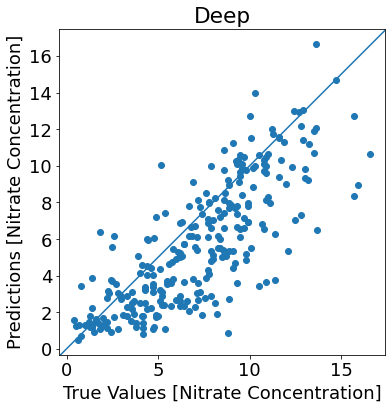

In [40]:
plt.figure(figsize=(6,6))
plt.scatter(test_labels_deep, test_predictions_deep)
plt.xlabel('True Values [Nitrate Concentration]')
plt.ylabel('Predictions [Nitrate Concentration]')
plt.title('Deep')
plt.axis('equal')
plt.axis('square')
_ = plt.plot([-300, 500], [-300, 500])

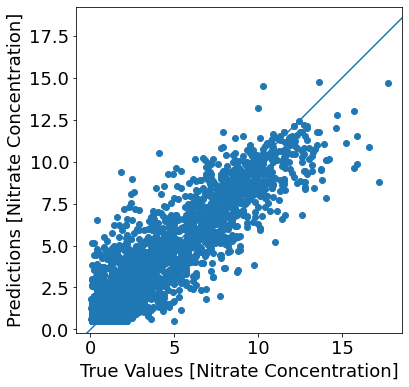

In [79]:
plt.figure(figsize=(6,6))
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Nitrate Concentration]')
plt.ylabel('Predictions [Nitrate Concentration]')
plt.axis('equal')
plt.axis('square')
_ = plt.plot([-300, 500], [-300, 500])

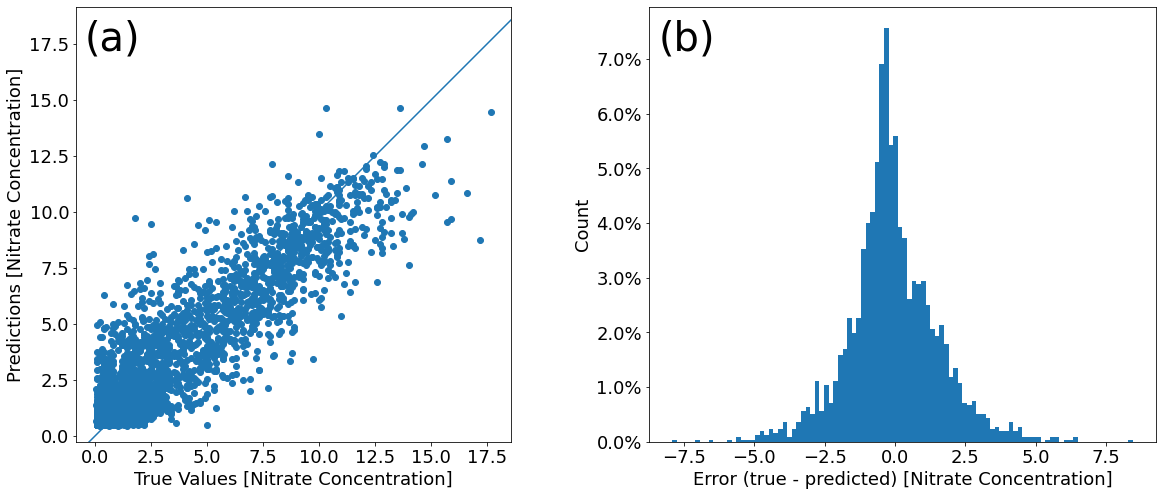

In [156]:
# plt.figure(figsize=(6,6))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
axes[0].scatter(test_labels, test_predictions)
axes[0].set_xlabel('True Values [Nitrate Concentration]')
axes[0].set_ylabel('Predictions [Nitrate Concentration]')
axes[0].axis('equal')
axes[0].axis('square')
axes[0].text(0.02,0.9, "(a)", transform=axes[0].transAxes, fontsize=40)
_ = axes[0].plot([-300, 500], [-300, 500])


# plt.figure(figsize=(8,6))
error = (test_labels - test_predictions)
axes[1].hist(error, bins = 100,  weights=np.ones(len(error)) / len(error))
# axes[1].set_xlim([-20,1.5])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
axes[1].set_xlabel("Error (true - predicted) [Nitrate Concentration]")
axes[1].text(0.02,0.9, "(b)", transform=axes[1].transAxes, fontsize=40)
_ = axes[1].set_ylabel("Count")

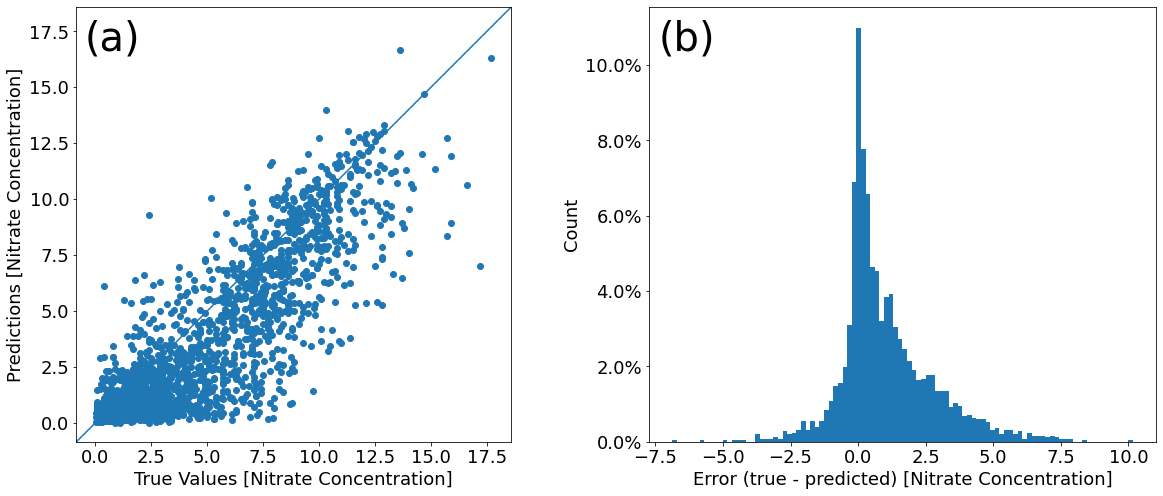

In [159]:
# original model with mape as loss

# plt.figure(figsize=(6,6))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
axes[0].scatter(test_labels, test_predictions)
axes[0].set_xlabel('True Values [Nitrate Concentration]')
axes[0].set_ylabel('Predictions [Nitrate Concentration]')
axes[0].axis('equal')
axes[0].axis('square')
axes[0].text(0.02,0.9, "(a)", transform=axes[0].transAxes, fontsize=40)
_ = axes[0].plot([-300, 500], [-300, 500])


# plt.figure(figsize=(8,6))
error = (test_labels - test_predictions)
axes[1].hist(error, bins = 100,  weights=np.ones(len(error)) / len(error))
# axes[1].set_xlim([-20,1.5])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
axes[1].set_xlabel("Error (true - predicted) [Nitrate Concentration]")
axes[1].text(0.02,0.9, "(b)", transform=axes[1].transAxes, fontsize=40)
_ = axes[1].set_ylabel("Count")

(array([1., 0., 0., 0., 2., 5., 0., 4., 3., 1., 0., 2., 0., 0., 0., 0., 1.,
        2., 1., 0., 2., 2., 0., 0., 1., 0., 2., 0., 1., 0., 0., 0., 1., 1.,
        1., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.582699  , 0.69886774, 0.81503654, 0.9312053 , 1.047374  ,
        1.1635427 , 1.2797115 , 1.3958802 , 1.5120491 , 1.6282178 ,
        1.7443866 , 1.8605553 , 1.976724  , 2.092893  , 2.2090616 ,
        2.3252304 , 2.441399  , 2.5575678 , 2.6737366 , 2.7899053 ,
        2.906074  , 3.0222428 , 3.1384115 , 3.2545803 , 3.370749  ,
        3.4869177 , 3.6030865 , 3.7192554 , 3.8354242 , 3.951593  ,
        4.0677614 , 4.1839304 , 4.300099  , 4.416268  , 4.5324364 ,
        4.6486053 , 4.7647743 , 4.880943  , 4.997112  , 5.1132803 ,
        5.2294493 , 5.345618  , 5.4617867 , 5.5779552 , 5.694124  ,
        5.8102927 , 5.9264617 , 6.04263   , 6.158799  , 6.2749677 ,
        6.3911366 ], dtype=float32),
 <a list of 50 Patch objects>)

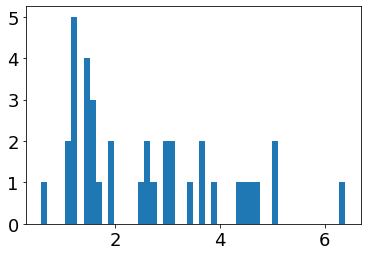

In [65]:
perc_error = (test_labels-test_predictions)/test_labels
plt.hist(test_predictions[perc_error < -10], bins=50)

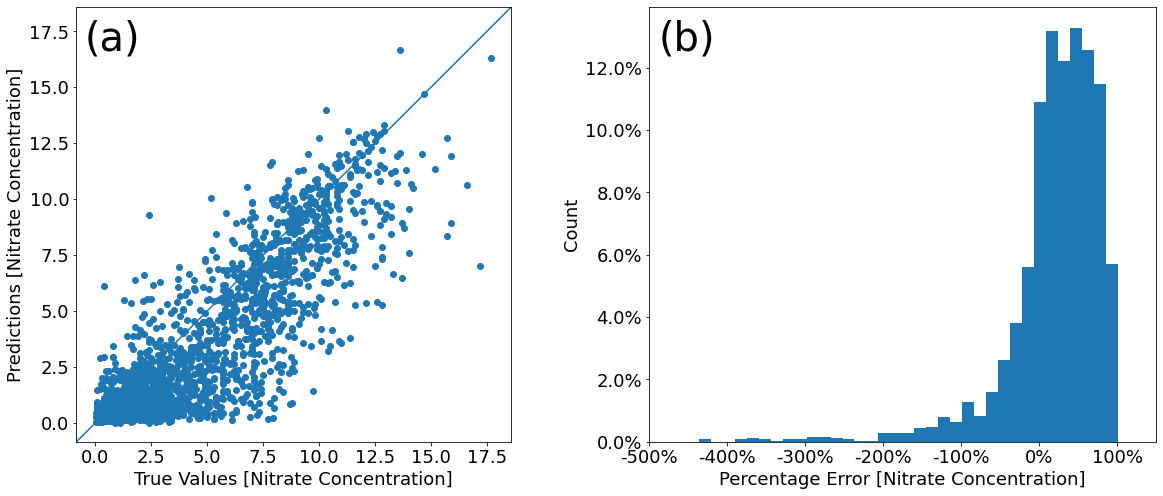

In [235]:
# plt.figure(figsize=(6,6))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
axes[0].scatter(test_labels, test_predictions)
axes[0].set_xlabel('True Values [Nitrate Concentration]')
axes[0].set_ylabel('Predictions [Nitrate Concentration]')
axes[0].axis('equal')
axes[0].axis('square')
axes[0].text(0.02,0.9, "(a)", transform=axes[0].transAxes, fontsize=40)
_ = axes[0].plot([-300, 500], [-300, 500])


# plt.figure(figsize=(8,6))
error = (test_labels - test_predictions)/test_labels
axes[1].hist(error, bins = 100,  weights=np.ones(len(error)) / len(error))
axes[1].set_xlim([-5,1.5])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
axes[1].set_xlabel("Percentage Error [Nitrate Concentration]")
axes[1].text(0.02,0.9, "(b)", transform=axes[1].transAxes, fontsize=40)
_ = axes[1].set_ylabel("Count")

In [236]:
# nitrate values between 0 and 24: percentage error
min(error)*100, max(error)*100

(-1431.7381620407102, 100.61118450354446)

In [164]:
# nitrate values between 0 and 24 (only <3% nitrate values are below 1) and 24 and pressure between 80 and 120 
error = test_labels - test_predictions
min(error), max(error)

(-7.130657768249511, 9.695646667480469)

In [237]:
# nitrate values between 0 and 24
error = test_labels - test_predictions
min(error), max(error)

(-6.8872638702392575, 10.171709728240966)

In [221]:
# nitrate values between 0 and 24 and model with regularization
error = test_labels - test_predictions
min(error), max(error)

(-6.070686912536621, 10.290384483337402)

In [184]:
# nitrate values between 0 and 24 with oxygen as a predictor
error = test_labels - test_predictions
min(error), max(error)

(-9.345429039001464, 19.480337023735046)

In [196]:
# nitrate values between 0 and 24 and year until 1985
error = test_labels - test_predictions
min(error), max(error)

(-6.259209251403808, 9.378905010223388)

In [112]:
# nitrate values between 0 and 15
error = test_labels - test_predictions
min(error), max(error)

(-8.008899307250976, 14.525625574588776)

In [93]:
# nitrate values between 0 and 15 and logtransform before modeling and invlog_mape as loss
error = test_labels - test_predictions
min(error), max(error)

(-11.154821968078613, 14.193672943115239)

(array([  1.,   5.,   4.,   5.,  14.,  35., 111., 666., 731., 155.]),
 array([-3.18806352, -2.77989018, -2.37171684, -1.96354349, -1.55537015,
        -1.14719681, -0.73902347, -0.33085012,  0.07732322,  0.48549656,
         0.8936699 ]),
 <a list of 10 Patch objects>)

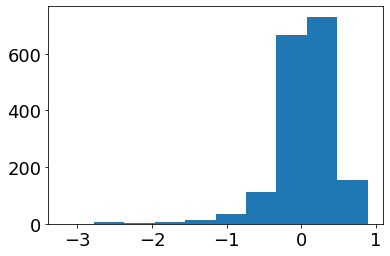

In [72]:
error = (test_labels - test_predictions)/test_labels
min(error), max(error)
plt.hist(error)

In [44]:
# error.iloc[error.argmin()] = np.nan
# error.dropna(inplace=True)

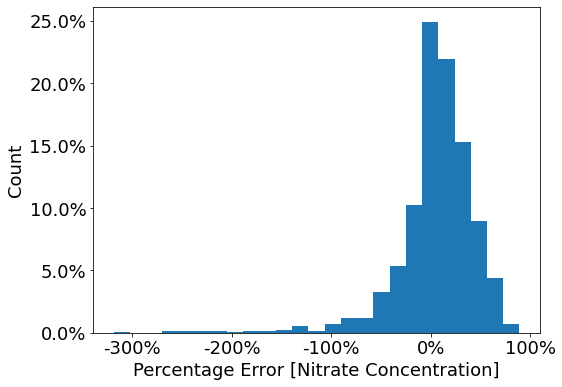

In [73]:
plt.figure(figsize=(8,6))
plt.hist(error, bins = 25,  weights=np.ones(len(error)) / len(error))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("Percentage Error [Nitrate Concentration]")
_ = plt.ylabel("Count")

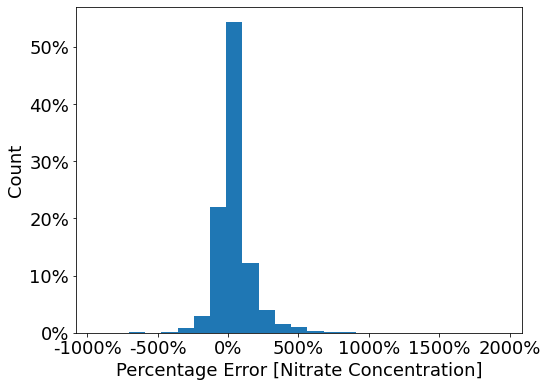

In [185]:
# nitrate values between 0 and 24 with oxygen as a predictor
plt.figure(figsize=(8,6))
plt.hist(error, bins = 25,  weights=np.ones(len(error)) / len(error))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("Percentage Error [Nitrate Concentration]")
_ = plt.ylabel("Count")

(array([  1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   2.,   1.,
          1.,   1.,   4.,   9.,  10.,  19.,  29.,  57., 218., 526., 136.,
          7.,   1.,   1.]),
 array([-718.04377238, -682.47515541, -646.90653844, -611.33792146,
        -575.76930449, -540.20068752, -504.63207055, -469.06345357,
        -433.4948366 , -397.92621963, -362.35760266, -326.78898569,
        -291.22036871, -255.65175174, -220.08313477, -184.5145178 ,
        -148.94590082, -113.37728385,  -77.80866688,  -42.24004991,
          -6.67143294,   28.89718404,   64.46580101,  100.03441798,
         135.60303495,  171.17165192]),
 <a list of 25 Patch objects>)

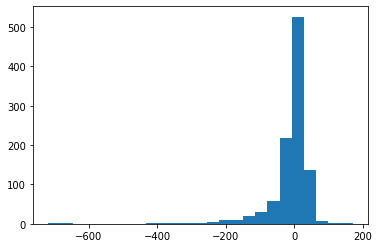

In [147]:
plt.hist(error, bins=25)

In [89]:
len(error)

1727

In [90]:
idx_large_error = np.where(np.abs(error) > 100)

In [91]:
large_error_test_dataset = test_dataset.iloc[idx_large_error]
large_error_test_dataset

,Year,Yday,Hour,PRESSURE,TEMPERATURE_VALUE,SALINITY_VALUE
111,-1.790849,0.754727,-0.289688,1.538778,-1.524726,-0.554469
141,-1.790849,1.140974,-0.289688,-0.221392,-0.073668,-1.806710
269,-1.700694,-0.869491,-0.289688,-0.221392,2.073898,-1.493650
395,-1.700694,0.596267,-0.289688,-0.573426,-0.073668,-0.232713
747,-1.610539,0.487325,-0.289688,-0.221392,-0.538006,-0.232713
...,...,...,...,...,...,...
15025,2.536588,1.319242,3.494570,-1.101477,1.716938,1.245627
15154,2.716897,1.091455,3.150546,0.869914,-1.507313,-0.884922
15208,2.807052,1.269723,3.322558,-1.981563,1.449943,0.176004
15350,3.077517,0.279346,-0.117676,-1.629528,0.204935,0.906478


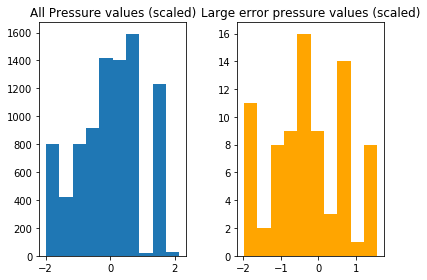

In [110]:
plt.subplot(1,2,1)
plt.hist(nitrate.PRESSURE)
plt.title("All Pressure values (scaled)")
plt.subplot(1,2,2)
plt.hist(large_error_test_dataset.PRESSURE, color="orange")
plt.title("Large error pressure values (scaled)")
plt.tight_layout()
# plt.ylim([0,200])
# plt.legend()

Text(0.5, 1.0, 'Large error temperature values (scaled)')

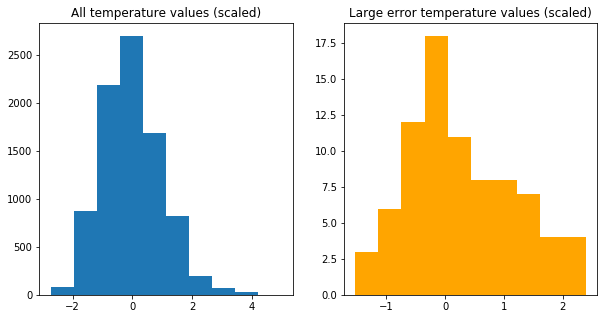

In [120]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].hist(nitrate.TEMPERATURE_VALUE)
axes[0].set_title("All temperature values (scaled)")
# plt.subplot(1,2,2)
axes[1].hist(large_error_test_dataset.TEMPERATURE_VALUE, color = "orange")
axes[1].set_title("Large error temperature values (scaled)")

Text(0.5, 1.0, 'Large error hour values (scaled)')

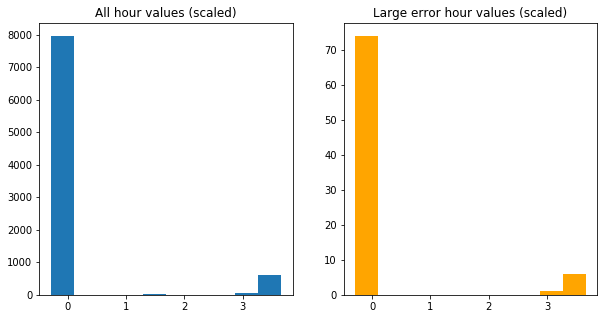

In [121]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].hist(nitrate.Hour)
axes[0].set_title("All hour values (scaled)")
# plt.subplot(1,2,2)
axes[1].hist(large_error_test_dataset.Hour, color = "orange")
axes[1].set_title("Large error hour values (scaled)")

(array([2990., 1427., 1188., 1276.,  993.,  534.,  183.,   31.,    8.,
           3.]),
 array([ 1.01 ,  2.909,  4.808,  6.707,  8.606, 10.505, 12.404, 14.303,
        16.202, 18.101, 20.   ]),
 <a list of 10 Patch objects>)

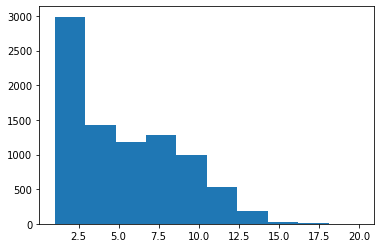

In [169]:
plt.hist(nitrate.NITRATE_VALUE)

(array([31., 20.,  8.,  2.,  9.,  5.,  1.,  1.,  2.,  2.]),
 array([1.04 , 1.346, 1.652, 1.958, 2.264, 2.57 , 2.876, 3.182, 3.488,
        3.794, 4.1  ]),
 <a list of 10 Patch objects>)

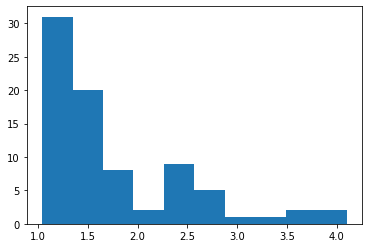

In [171]:
plt.hist(test_labels.iloc[idx_large_error])

(array([20., 23.,  7., 13.,  9.,  3.,  3.,  0.,  1.,  2.]),
 array([ 2.2800972,  3.1649504,  4.0498033,  4.9346566,  5.8195095,
         6.7043624,  7.5892158,  8.474069 ,  9.358922 , 10.243774 ,
        11.128628 ], dtype=float32),
 <a list of 10 Patch objects>)

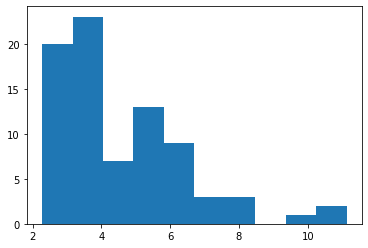

In [173]:
plt.hist(test_predictions[idx_large_error])

In [51]:
import pickle

In [238]:
pickle_in = open("../data/standardisation_nitrate.pickle", "rb")
nitrate_stats = pickle.load(pickle_in)
pickle_in.close()
nitrate_stats.drop(['TEMPERATURE_QC_FLAG','SALINITY_QC_FLAG','NITRATE_QC_FLAG','NITRATE_VALUE'], inplace=True)
nitrate_stats

,count,mean,std,min,25%,50%,75%,max
Year,12606.0,1973.574488,11.034516,1953.000,1966.00,1973.000,1979.00000,2010.000
Yday,12606.0,186.710138,102.996119,1.000,99.00,192.000,273.00000,365.000
Hour,12606.0,1.631128,5.724349,0.000,0.00,0.000,0.00000,23.000
PRESSURE,12606.0,45.228740,30.717783,0.000,20.00,40.000,70.00000,117.000
TEMPERATURE_VALUE,12606.0,17.334803,2.231818,11.740,15.70,17.022,18.70825,25.230
SALINITY_VALUE,12606.0,35.471884,0.122632,35.005,35.39,35.480,35.55700,35.791


In [124]:
large_error_test_dataset = large_error_test_dataset * nitrate_stats['std'] + nitrate_stats['mean']

In [126]:
nitrate_descaled = nitrate * nitrate_stats['std'] + nitrate_stats['mean']

In [125]:
large_error_test_dataset.describe() - nitrate_stats.transpose()

,Year,Yday,Hour,PRESSURE,TEMPERATURE_VALUE,SALINITY_VALUE
count,-8552.000000,-8552.000000,-8.552000e+03,-8552.000000,-8552.000000,-8552.000000
mean,-0.567830,20.860391,1.924241e-01,-5.016098,0.471783,0.027918
std,1.995614,-16.003433,2.884560e-01,-0.513243,-0.143024,-0.024372
min,1.000000,6.000000,2.220446e-16,0.000000,2.060000,0.222000
25%,-3.000000,41.000000,2.220446e-16,-10.000000,0.567000,0.059000
50%,-1.000000,20.000000,2.220446e-16,-3.000000,0.323000,0.034000
75%,1.000000,5.000000,2.220446e-16,0.000000,0.500000,0.003000
max,-1.000000,-8.000000,0.000000e+00,-15.900000,-4.460000,-0.084000


In [126]:
large_error_test_dataset.describe()

,Year,Yday,Hour,PRESSURE,TEMPERATURE_VALUE,SALINITY_VALUE
count,81.000000,81.000000,8.100000e+01,81.000000,81.000000,81.000000
mean,1973.296296,210.654321,1.876543e+00,51.272840,16.898704,35.480679
std,13.087632,84.968253,6.102013e+00,27.893095,1.579856,0.090621
min,1954.000000,7.000000,2.220446e-16,0.000000,13.800000,35.231000
25%,1964.000000,144.000000,2.220446e-16,30.000000,15.800000,35.434000
50%,1972.000000,221.000000,2.220446e-16,50.000000,16.623000,35.489000
75%,1980.000000,276.000000,2.220446e-16,75.000000,18.000000,35.538000
max,2009.000000,357.000000,2.300000e+01,101.100000,20.550000,35.703000


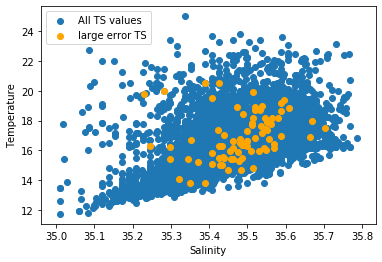

In [131]:
plt.scatter(nitrate_descaled.SALINITY_VALUE, nitrate_descaled.TEMPERATURE_VALUE, label="All TS values")
plt.scatter(large_error_test_dataset.SALINITY_VALUE, large_error_test_dataset.TEMPERATURE_VALUE, c="orange", label="large error TS")
plt.xlabel("Salinity")
plt.ylabel("Temperature")
plt.legend()

In [66]:
rescaled_test_dataset = test_dataset * nitrate_stats['std'] + nitrate_stats['mean']

Text(0, 0.5, 'Salinity (g/m^3)')

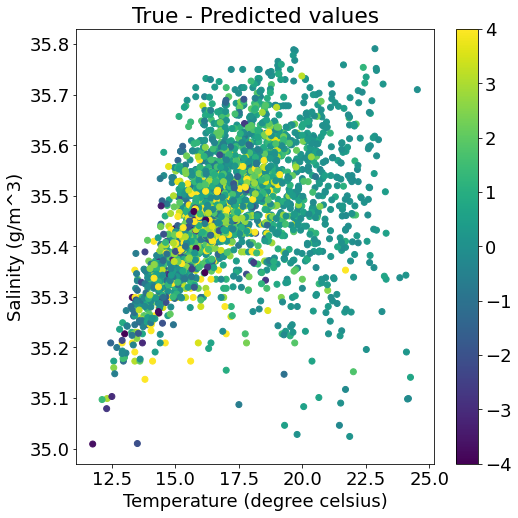

In [240]:
plt.figure(figsize=(8,8))
plt.scatter(rescaled_test_dataset.TEMPERATURE_VALUE, rescaled_test_dataset.SALINITY_VALUE, c=test_labels-test_predictions, vmin=-4, vmax=4)
plt.colorbar()
plt.title("True - Predicted values")
plt.xlabel("Temperature (degree celsius)")
plt.ylabel("Salinity (g/m^3)")

In [67]:
import datetime 

In [68]:
yd = [datetime.timedelta(yd - 1) for yd in rescaled_test_dataset.Yday.astype(int)]
y = [datetime.datetime(y, 1, 1) for y in rescaled_test_dataset.Year.astype(int)] 

In [70]:
time = [a + b for a,b in zip(y, yd)] 

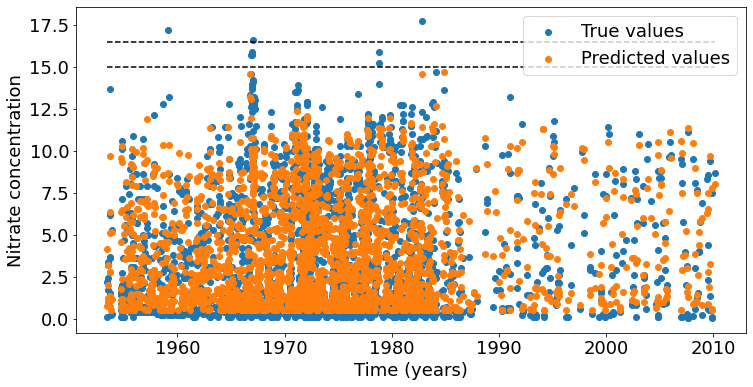

In [71]:
plt.figure(figsize=(12,6))
plt.scatter(time, test_labels, label="True values")
plt.scatter(time, test_predictions, label="Predicted values")
plt.xlabel("Time (years)")
plt.ylabel("Nitrate concentration")
plt.hlines([16.45,15], xmin=min(time), xmax=max(time), linestyles='dashed')
plt.legend()

In [199]:
# Nitrate between 0 and 24 and year until 1985
yd = [datetime.timedelta(yd - 1) for yd in rescaled_test_dataset.Yday.astype(int)]
y = [datetime.datetime(y, 1, 1) for y in rescaled_test_dataset.Year.astype(int)] 

In [200]:
time = [a + b for a,b in zip(y, yd)] 

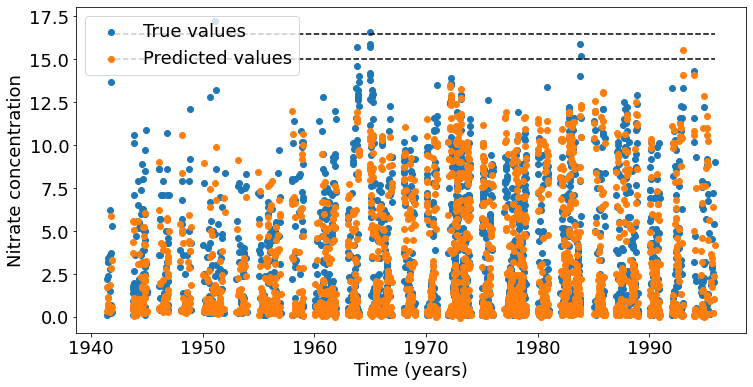

In [201]:
# Nitrate between 0 and 24 and year until 1985
plt.figure(figsize=(12,6))
plt.scatter(time, test_labels, label="True values")
plt.scatter(time, test_predictions, label="Predicted values")
plt.xlabel("Time (years)")
plt.ylabel("Nitrate concentration")
plt.hlines([16.45,15], xmin=min(time), xmax=max(time), linestyles='dashed')
plt.legend()

In [168]:
nitrate_descaled = nitrate_descaled.assign(dtime_str = lambda x: x.Year.astype(int).astype(str)+" "+x.Yday.astype(int).astype(str)+" "+x.Hour.astype(int).astype(str))
nitrate_descaled["datetime"] = [datetime.datetime.strptime(y, "%Y %j %H") for y in nitrate_descaled.dtime_str]
# type(nitrate_descaled)
# [ datetime.datetime.strptime("%s %s %s" % (y, d, h), "%Y %j %H") 
#  for y,d in zip(nitrate_descaled.Year.astype(int), nitrate_descaled.Yday.astype(int), nitrate_descaled.Hour.astype(int))]
# datetime.datetime.strptime("%s %s" % (nitrate_descaled.Year.astype(int),  nitrate_descaled.Yday.astype(int)), "%Y %j")

In [127]:
nitrate_descaled

,Hour,NITRATE_VALUE,PRESSURE,SALINITY_VALUE,TEMPERATURE_VALUE,Yday,Year
1,0.0,NaN,10.0,35.371,18.600,151.0,1953.0
3,0.0,NaN,30.0,35.462,18.800,151.0,1953.0
6,0.0,NaN,75.0,35.480,17.100,151.0,1953.0
7,0.0,NaN,100.0,35.570,16.200,151.0,1953.0
10,0.0,NaN,20.0,35.389,18.000,160.0,1953.0
...,...,...,...,...,...,...,...
15535,22.0,NaN,10.0,35.427,22.768,76.0,2010.0
15537,22.0,NaN,25.0,35.492,19.530,76.0,2010.0
15540,22.0,NaN,50.0,35.428,16.060,76.0,2010.0
15542,22.0,NaN,75.0,35.321,14.716,76.0,2010.0


(array([4180., 4088., 3151., 1323.,  133.,  132.,   69.,   15.,   58.,
          44.]),
 array([  0.,  30.,  60.,  90., 120., 150., 180., 210., 240., 270., 300.]),
 <a list of 10 Patch objects>)

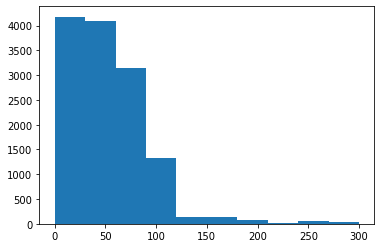

In [128]:
plt.hist(nitrate_descaled.PRESSURE)

In [94]:
nitrate_stats

,count,mean,std,min,25%,50%,75%,max
Year,13193.0,1973.573259,10.881569,1953.000,1966.000,1973.000,1979.000,2010.000
Yday,13193.0,185.897294,103.373658,1.000,97.000,191.000,273.000,365.000
Hour,13193.0,1.569923,5.623926,0.000,0.000,0.000,0.000,23.000
PRESSURE,13193.0,49.625294,40.673437,0.000,20.000,50.000,75.000,300.000
TEMPERATURE_VALUE,13193.0,17.268298,2.314093,10.110,15.600,16.988,18.690,25.230
SALINITY_VALUE,13193.0,35.458125,0.159694,31.924,35.384,35.472,35.552,35.967


In [68]:
nitrate_descaled = nitrate * nitrate_stats['std'] + nitrate_stats['mean']

In [69]:
len(np.where((nitrate_descaled.PRESSURE > 85) & (nitrate_descaled.PRESSURE < 115))[0])

1271

In [70]:
test_dataset

,Year,Yday,Hour,PRESSURE,TEMPERATURE_VALUE,SALINITY_VALUE
3,-1.881004,-0.384206,-0.289688,-0.925460,1.377390,0.080347
24,-1.881004,-0.096997,-0.289688,-1.981563,0.622840,0.393407
42,-1.881004,0.051560,-0.289688,-1.277494,0.332628,0.862998
45,-1.881004,0.051560,-0.289688,-0.221392,0.332628,-0.076183
46,-1.881004,0.051560,-0.289688,0.658693,0.216544,0.080347
...,...,...,...,...,...,...
15458,3.167672,0.725016,3.494570,-1.101477,-0.950107,-0.815353
15494,3.167672,1.002321,3.666581,1.538778,-0.613462,-0.537077
15513,3.167672,1.487606,3.494570,0.658693,-0.275655,0.019474
15533,3.257827,-1.394390,3.666581,1.538778,-1.309969,-1.276247


In [71]:
large_error_comp = pd.DataFrame({'test_labels': test_labels.iloc[idx_large_error], 
                                 'test_predictions': test_predictions[idx_large_error]})
large_error_comp

,test_labels,test_predictions
111,1.40,3.544721
141,2.50,6.551746
269,1.20,4.042725
395,1.30,2.877624
687,1.40,2.951205
...,...,...
15025,1.20,3.669844
15154,4.10,11.023280
15208,1.18,4.695668
15350,1.55,3.224678


In [72]:
large_error_comp.describe()

,test_labels,test_predictions
count,61.000000,61.000000
mean,1.799672,4.906625
std,0.722182,1.924031
min,1.040000,2.260412
25%,1.210000,3.257059
50%,1.500000,4.387197
75%,2.300000,6.107732
max,4.100000,11.023280


Text(0, 0.5, 'Count')

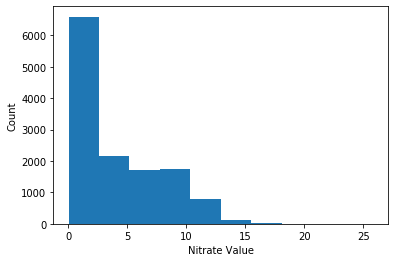

In [59]:
plt.hist(nitrate.NITRATE_VALUE)
plt.xlabel('Nitrate Value')
plt.ylabel('Count')

In [60]:
len(np.where(test_predictions < 0))

1

In [ ]:
large_error_df = pd.concat()

## Regularization

In [50]:
from tensorflow.keras import regularizers

In [106]:
def build_model():
    model = keras.Sequential([
      layers.Dense(64, activation='tanh', input_shape=[len(train_dataset.keys())], kernel_regularizer=regularizers.l2(0.01)),
      layers.Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
      layers.Dense(16, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
      layers.Dense(8, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
      layers.Dense(1)
    ])
    
    optimizer = 'adam' #tf.keras.optimizers.RMSprop()
    
    model.compile(loss=tf.keras.losses.mean_absolute_percentage_error,
                 optimizer=optimizer,
                 metrics=['mae', 'mse', tf.keras.metrics.MeanAbsolutePercentageError()])
    
    return model

In [107]:
model = build_model()

In [108]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 64)                448       
_________________________________________________________________
dense_52 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_53 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_54 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 9         
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________


In [111]:
## Train the model
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 10 == 0: print('loss: {:7.4f}, val_loss: {:7.4f}' .format(logs['loss'], logs['val_loss']))
    print('.', end='')

# early stopping callback
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

EPOCHS = 1000

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

loss: 17.6296, val_loss: 19.2906
..........loss: 17.6315, val_loss: 18.9879
..........loss: 17.5829, val_loss: 19.1780
..........loss: 17.5064, val_loss: 19.2419
..........loss: 17.2769, val_loss: 19.2200
..........loss: 17.2098, val_loss: 19.8029
..........loss: 17.2758, val_loss: 19.2748
..........loss: 17.1808, val_loss: 19.7597
..........loss: 17.1424, val_loss: 19.3193
..........loss: 17.0332, val_loss: 19.9480
..........loss: 17.1425, val_loss: 20.7775
..........loss: 16.8972, val_loss: 19.4761
..........loss: 16.8923, val_loss: 19.6720
..........loss: 16.8207, val_loss: 19.8389
..........loss: 16.7048, val_loss: 19.5194
..........loss: 16.7384, val_loss: 19.3958
..........loss: 16.6990, val_loss: 19.9270
..........loss: 16.6131, val_loss: 19.5677
..........loss: 16.6618, val_loss: 19.7908
..........loss: 16.4862, val_loss: 20.2902
..........loss: 16.5336, val_loss: 19.8735
..........loss: 16.4696, val_loss: 19.9293
..........loss: 16.3364, val_loss: 20.0576
..........loss: 16.29

In [60]:
pd.DataFrame(history.history).describe()

,loss,mae,mse,mean_absolute_percentage_error,val_loss,val_mae,val_mse,val_mean_absolute_percentage_error
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1.377218,0.757244,1.272793,19.528616,1.704359,0.837728,1.599889,20.982875
std,0.020711,0.005422,0.023956,0.172212,0.081569,0.026416,0.081638,1.057210
min,1.339996,0.745886,1.231176,19.162395,1.597022,0.800474,1.497747,19.652651
25%,1.360380,0.752970,1.254022,19.409737,1.650521,0.820044,1.548726,20.214632
50%,1.374588,0.757239,1.270243,19.551442,1.685808,0.830819,1.579922,20.806077
75%,1.393096,0.760667,1.291011,19.636428,1.733604,0.850222,1.630315,21.530215
max,1.422806,0.770492,1.324551,19.931057,2.035595,0.940015,1.929733,25.123669


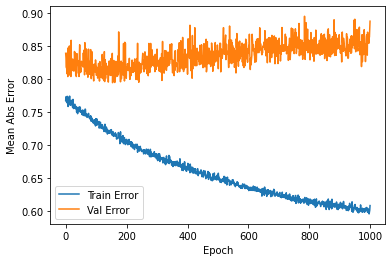

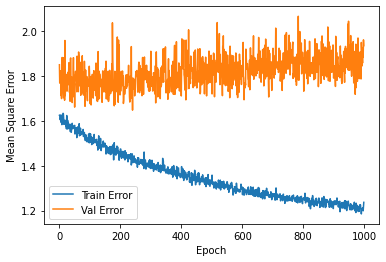

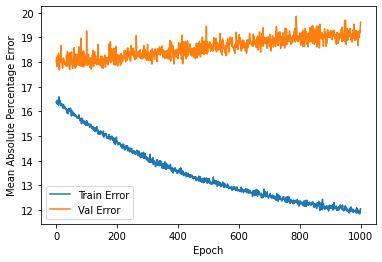

In [112]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
#   plt.ylim([0.9,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
#   plt.ylim([1.8,7])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
  #plt.ylim([80,160])
  plt.legend()
  plt.show()


plot_history(history)

In [26]:
# Dropout

def build_model():
    model = keras.Sequential([
      layers.Dense(512, activation='relu', input_shape=[len(train_dataset.keys())]),
      layers.Dropout(0.2),
      layers.Dense(256, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(8, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop()
    
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae', 'mse', tf.keras.metrics.MeanAbsolutePercentageError()])
    
    return model

In [27]:
model = build_model()

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 512)               3584      
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 8)                

In [29]:
# Try out model with example batch
example_batch = train_dataset[:10]
example_result = model.predict(example_batch)
example_result

array([[0.02398698],
       [0.12459408],
       [0.08351785],
       [0.01977466],
       [0.08826135],
       [0.13829444],
       [0.06811555],
       [0.05041648],
       [0.01989299],
       [0.10928319]], dtype=float32)

In [30]:
## Train the model
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................

In [31]:
pd.DataFrame(history.history).describe()

,loss,mae,mse,mean_absolute_percentage_error,val_loss,val_mae,val_mse,val_mean_absolute_percentage_error
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,3.650891,1.394736,3.650891,36.260292,3.053179,1.273415,3.053179,37.462547
std,0.896836,0.148726,0.896836,1.799628,0.383850,0.082761,0.383850,2.072297
min,2.811973,1.240813,2.811973,34.832699,2.710922,1.184993,2.710922,32.957153
25%,3.001090,1.289539,3.001089,35.456997,2.840459,1.223434,2.840458,36.470401
50%,3.297271,1.340985,3.297271,35.769667,2.938647,1.248815,2.938647,37.356159
75%,3.974422,1.447635,3.974420,36.168791,3.120779,1.298161,3.120779,38.259933
max,7.826931,2.054883,7.826931,47.549355,5.385348,1.730634,5.385348,51.193836


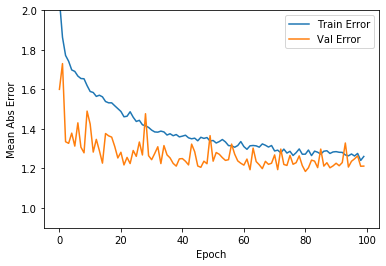

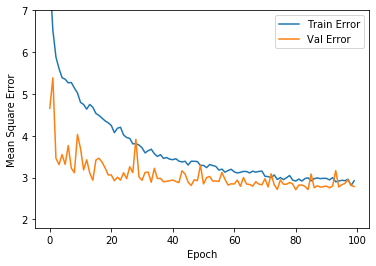

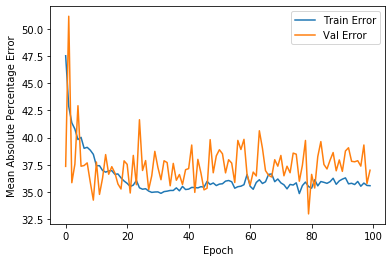

In [32]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0.9,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([1.8,7])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
  #plt.ylim([80,160])
  plt.legend()
  plt.show()


plot_history(history)

In [33]:
## Train the model
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................

In [34]:
pd.DataFrame(history.history).describe()

,loss,mae,mse,mean_absolute_percentage_error,val_loss,val_mae,val_mse,val_mean_absolute_percentage_error
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2.738169,1.226902,2.738169,35.224984,2.780224,1.215663,2.780224,37.519966
std,0.078373,0.019144,0.078373,0.463564,0.070153,0.028984,0.070153,1.570316
min,2.550224,1.177760,2.550224,33.880344,2.636920,1.160009,2.636919,33.340538
25%,2.674044,1.211081,2.674044,34.880694,2.728418,1.195471,2.728417,36.402322
50%,2.728486,1.224548,2.728486,35.166218,2.770704,1.211758,2.770704,37.792889
75%,2.798887,1.244116,2.798887,35.545717,2.824836,1.235306,2.824836,38.431901
max,2.904076,1.264598,2.904076,36.314838,3.043350,1.313808,3.043350,41.528221


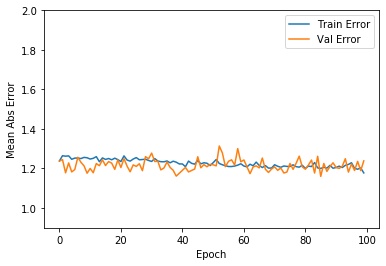

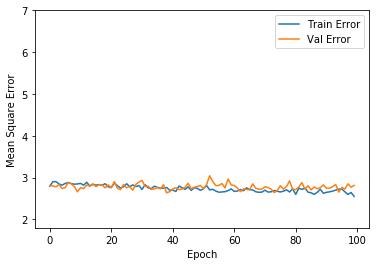

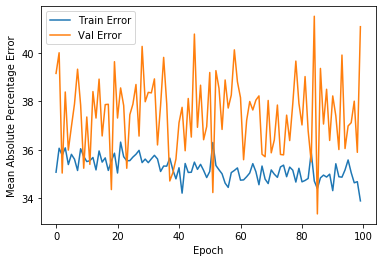

In [35]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0.9,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([1.8,7])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
  #plt.ylim([80,160])
  plt.legend()
  plt.show()


plot_history(history)

*Increase complexity!*

In [36]:
# Dropout

def build_model():
    model = keras.Sequential([
      layers.Dense(1024, activation='relu', input_shape=[len(train_dataset.keys())]),
      layers.Dropout(0.2),
      layers.Dense(512, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(256, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(8, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop()
    
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae', 'mse', tf.keras.metrics.MeanAbsolutePercentageError()])
    
    return model

In [37]:
model = build_model()

In [38]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 1024)              7168      
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)              

In [40]:
## Train the model
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................

In [41]:
pd.DataFrame(history.history).describe()

,loss,mae,mse,mean_absolute_percentage_error,val_loss,val_mae,val_mse,val_mean_absolute_percentage_error
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,3.835541,1.424662,3.835541,37.074840,3.132424,1.291980,3.132424,38.131111
std,1.140432,0.179721,1.140432,1.941445,0.551366,0.110763,0.551366,2.400903
min,2.844842,1.251212,2.844841,35.248749,2.686502,1.190274,2.686502,33.311462
25%,3.061863,1.302143,3.061863,36.278522,2.874549,1.231322,2.874549,36.305218
50%,3.383219,1.361867,3.383219,36.553907,2.971993,1.269732,2.971993,37.885082
75%,4.106801,1.467329,4.106802,36.984717,3.192732,1.309891,3.192732,39.677682
max,8.942276,2.199609,8.942280,49.528214,7.030513,2.014315,7.030513,45.471191


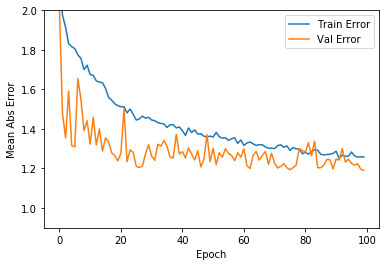

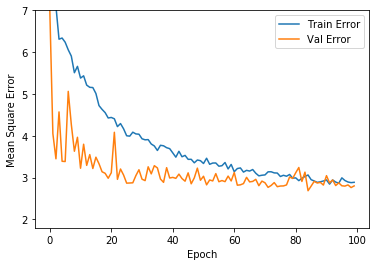

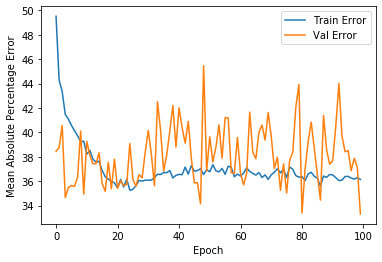

In [42]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0.9,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([1.8,7])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
  #plt.ylim([80,160])
  plt.legend()
  plt.show()


plot_history(history)

In [43]:
## Train the model for another 100 epochs
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................

In [44]:
pd.DataFrame(history.history).describe()

,loss,mae,mse,mean_absolute_percentage_error,val_loss,val_mae,val_mse,val_mean_absolute_percentage_error
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2.645430,1.202496,2.645430,35.014897,2.861304,1.227619,2.861304,38.010918
std,0.106750,0.026347,0.106750,0.604906,0.075528,0.029304,0.075528,2.284333
min,2.424249,1.151703,2.424249,33.485352,2.682542,1.175827,2.682541,33.304104
25%,2.566409,1.183567,2.566409,34.589264,2.808233,1.205065,2.808232,36.362545
50%,2.640727,1.200268,2.640729,35.035883,2.845078,1.223127,2.845077,37.973866
75%,2.720790,1.222807,2.720790,35.398572,2.902937,1.251714,2.902938,39.496066
max,2.885484,1.255691,2.885484,36.422970,3.099908,1.307348,3.099908,43.054363


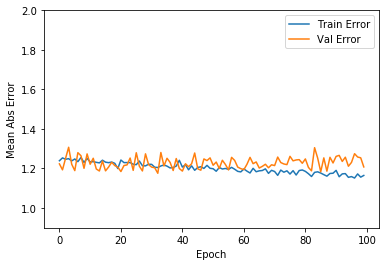

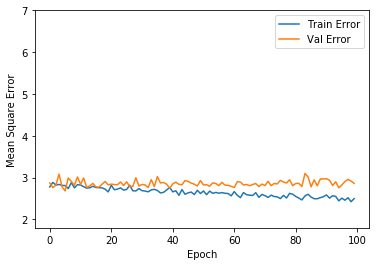

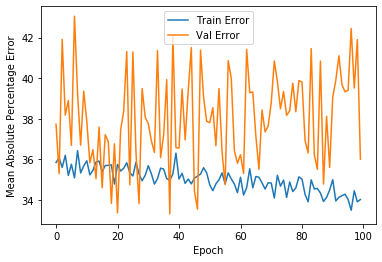

In [45]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0.9,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([1.8,7])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
  #plt.ylim([80,160])
  plt.legend()
  plt.show()


plot_history(history)

*Combined regularization with high complexity*

In [46]:
# Dropout

def build_model():
    model = keras.Sequential([
      layers.Dense(1024, activation='relu', input_shape=[len(train_dataset.keys())],kernel_regularizer=regularizers.l2(0.001)),
      layers.Dropout(0.2),
      layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
      layers.Dropout(0.2),
      layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
      layers.Dropout(0.2),
      layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
      layers.Dropout(0.2),
      layers.Dense(8, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
      layers.Dropout(0.2),
      layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop()
    
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae', 'mse', tf.keras.metrics.MeanAbsolutePercentageError()])
    
    return model

In [47]:
model = build_model()

In [48]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 1024)              7168      
_________________________________________________________________
dropout_13 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)              

In [49]:
## Train the model
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 200

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................

In [50]:
pd.DataFrame(history.history).describe()

,loss,mae,mse,mean_absolute_percentage_error,val_loss,val_mae,val_mse,val_mean_absolute_percentage_error
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,4.303126,1.537729,4.158177,42.629490,3.384975,1.368197,3.242579,43.379954
std,0.694057,0.082863,0.636889,1.592508,0.465224,0.080479,0.427361,2.481539
min,3.918306,1.481924,3.764416,37.154495,3.079515,1.250811,2.932963,34.264015
25%,4.038216,1.504131,3.896637,42.762173,3.207587,1.325792,3.076847,43.416080
50%,4.098811,1.515246,3.960970,43.051176,3.285138,1.354787,3.164510,44.075985
75%,4.219753,1.537251,4.098921,43.368457,3.408278,1.388572,3.282596,44.760581
max,9.814636,2.191384,8.861682,49.056442,7.225908,1.973549,6.930098,46.945122


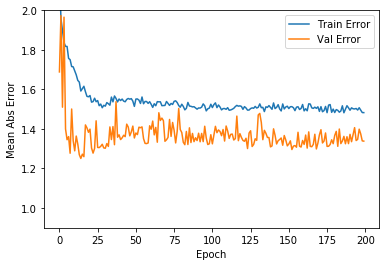

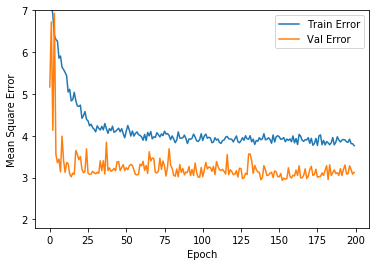

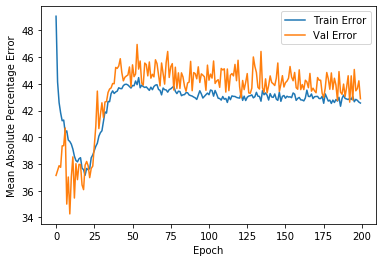

In [51]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0.9,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([1.8,7])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
  #plt.ylim([80,160])
  plt.legend()
  plt.show()


plot_history(history)